In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
dataset = pd.read_csv('combined-datasets/US_County_Level_All_Data.csv')

In [3]:
print("Dataset shape:", dataset.shape)
print("Dataset columns:", dataset.columns.tolist())

Dataset shape: (9245, 1427)
Dataset columns: ['year', 'state_name', 'fips', 'county_name', 'votes_gop', 'votes_dem', 'total_votes', 'diff', 'per_gop', 'per_dem', 'per_point_diff', 'unemployment_rate', 'TOT_POP_0', 'TOT_POP_1', 'TOT_POP_2', 'TOT_POP_3', 'TOT_POP_4', 'TOT_POP_5', 'TOT_POP_6', 'TOT_POP_7', 'TOT_POP_8', 'TOT_POP_9', 'TOT_POP_10', 'TOT_POP_11', 'TOT_POP_12', 'TOT_POP_13', 'TOT_POP_14', 'TOT_POP_15', 'TOT_POP_16', 'TOT_POP_17', 'TOT_POP_18', 'TOT_MALE_0', 'TOT_MALE_1', 'TOT_MALE_2', 'TOT_MALE_3', 'TOT_MALE_4', 'TOT_MALE_5', 'TOT_MALE_6', 'TOT_MALE_7', 'TOT_MALE_8', 'TOT_MALE_9', 'TOT_MALE_10', 'TOT_MALE_11', 'TOT_MALE_12', 'TOT_MALE_13', 'TOT_MALE_14', 'TOT_MALE_15', 'TOT_MALE_16', 'TOT_MALE_17', 'TOT_MALE_18', 'TOT_FEMALE_0', 'TOT_FEMALE_1', 'TOT_FEMALE_2', 'TOT_FEMALE_3', 'TOT_FEMALE_4', 'TOT_FEMALE_5', 'TOT_FEMALE_6', 'TOT_FEMALE_7', 'TOT_FEMALE_8', 'TOT_FEMALE_9', 'TOT_FEMALE_10', 'TOT_FEMALE_11', 'TOT_FEMALE_12', 'TOT_FEMALE_13', 'TOT_FEMALE_14', 'TOT_FEMALE_15', 'TOT_F

FEATURE-ENGINEERING

In [4]:
# dropping adjusted_voter_turnout since it is based on population instead of total votes
dataset = dataset.drop(columns=['adjusted_voter_turnout']) 
dataset = dataset.rename(columns={'adjusted_voter_turnout_votes': 'adjusted_voter_turnout'})

In [5]:
# converting all percentages to decimals
columns_to_modify = ['gop_pct_avg', 'dem_pct_avg', 'adjusted_gop_pct_estimate', 'adjusted_dem_pct_estimate', 'adjusted_gop_pct_bo_avg', 'adjusted_dem_pct_bo_avg']
dataset[columns_to_modify] = dataset[columns_to_modify] / 100
dataset[columns_to_modify] = dataset[columns_to_modify].astype('float64')

In [6]:
# removing columns_0 from dataset => since there is population age-wise
columns_0 = [column_name for column_name in dataset.columns if '_0' in column_name]
pop_column_names = [column_name.replace('_0', '') for column_name in columns_0]
pop_all_columns = [column_name for column_name in dataset.columns if ('MALE' in column_name or 'TOT' in column_name) and column_name not in columns_0]

print("pop_column_names length:", len(pop_column_names))
print("pop_all_columns length:", len(pop_all_columns))

pop_column_names length: 73
pop_all_columns length: 1314


In [7]:
# dropping columns_0 from dataset
dataset = dataset.drop(columns=columns_0)

In [8]:
# Define age partitions for each group
age_partitions = {
    'YA': list(range(1, 6)),   # 0-24 years: columns 1 to 5
    'WA': list(range(6, 12)),  # 25-64 years: columns 6 to 11
    'OA': list(range(12, 19))   # 65+ years: columns 12 to 18
}

# Function to generate the combined column names based on the age group
def get_combined_columns(base_name, age_range):
    return [f"{base_name}_{i}" for i in age_range]

# Initialize an empty list to store new column names
new_columns = []

# Create new columns for each of the 3 broad age groups for each gender and race group
for base_name in pop_column_names:  # List of column prefixes
    for group, age_range in age_partitions.items():
        # Get the combined column names for the current age group and gender/race
        cols = get_combined_columns(base_name, age_range)
        
        # Create a new column that sums across the age range for the current gender/race group
        new_column_name = f"{base_name}_{group}"
        dataset[new_column_name] = dataset[cols].sum(axis=1)

        # Add the new column to the new_columns list
        new_columns.append(new_column_name)

# Dropping the original age-specific columns if no longer needed
dataset.drop(columns=[col for col in pop_all_columns], inplace=True)

In [9]:
# Checking the dataset
dataset.head()

,year,state_name,fips,county_name,votes_gop,votes_dem,total_votes,diff,per_gop,per_dem,...,HAAC_MALE_OA,HAAC_FEMALE_YA,HAAC_FEMALE_WA,HAAC_FEMALE_OA,HNAC_MALE_YA,HNAC_MALE_WA,HNAC_MALE_OA,HNAC_FEMALE_YA,HNAC_FEMALE_WA,HNAC_FEMALE_OA
0,2016,Alabama,1001,Autauga County,18110,5908,24661,12202.0,0.734358,0.239569,...,1,5,5,1,9,6,0,5,6,1
1,2016,Alabama,1003,Baldwin County,72780,18409,94090,54371.0,0.773515,0.195653,...,9,33,19,3,17,15,2,18,12,3
2,2016,Alabama,1005,Barbour County,5431,4848,10390,583.0,0.522714,0.466603,...,0,1,0,0,3,10,0,7,4,0
3,2016,Alabama,1007,Bibb County,6733,1874,8748,4859.0,0.769662,0.214220,...,0,0,1,1,9,10,0,1,2,1
4,2016,Alabama,1009,Blount County,22808,2150,25384,20658.0,0.898519,0.084699,...,2,15,1,3,14,12,4,14,7,1


FEATURE-REDUCTION

In [10]:
# Getting only 2016 and 2020 data
train_dataset = dataset[dataset['year'] < 2024]

# Getting features and target data
features_data = train_dataset.copy()
features_data = features_data.drop(columns=['votes_gop', 'votes_dem', 'diff', 'per_gop', 'per_dem', 'per_point_diff', 'party_won', 'image_name'])
target_data = train_dataset[['per_gop', 'per_dem']]

In [11]:
print("Length of features data columns:", len(features_data.columns))
print("Features data column names:", features_data.columns)

Length of features data columns: 250
Features data column names: Index(['year', 'state_name', 'fips', 'county_name', 'total_votes',
       'unemployment_rate', 'POPESTIMATE', 'NPOPCHG', 'BIRTHS', 'DEATHS',
       ...
       'HAAC_MALE_OA', 'HAAC_FEMALE_YA', 'HAAC_FEMALE_WA', 'HAAC_FEMALE_OA',
       'HNAC_MALE_YA', 'HNAC_MALE_WA', 'HNAC_MALE_OA', 'HNAC_FEMALE_YA',
       'HNAC_FEMALE_WA', 'HNAC_FEMALE_OA'],
      dtype='object', length=250)


In [12]:
# Getting the columns with mostly zeros
numeric_features = features_data.copy()

numeric_features = numeric_features.drop(columns=['year', 'state_name', 'fips', 'county_name'])

# Filter only int64 columns
int_columns = numeric_features.select_dtypes(include=['int64'])

# Calculate the proportion of 0's in each column
zero_proportion = (int_columns == 0).mean()

# Set a threshold for "mostly 0's" (e.g., 0.8 means at least 80% 0's)
threshold = 0.60

# Get columns where the proportion of 0's is greater than the threshold
mostly_zeros_columns = zero_proportion[zero_proportion > threshold].index

print("Columns with mostly 0's:")
print(mostly_zeros_columns)

Columns with mostly 0's:
Index(['HNA_MALE_OA', 'HNA_FEMALE_OA'], dtype='object')


In [13]:
# Dropping mostly zero columns
features_data = features_data.drop(columns=mostly_zeros_columns)

In [14]:
# Getting columns whose unique values are less than 11% of the data length
numeric_features = features_data.copy()

numeric_features = numeric_features.drop(columns=['year', 'state_name', 'fips', 'county_name'])

# Filter only int64 columns
int_columns = numeric_features.select_dtypes(include=['int64'])

unique_counts = int_columns.nunique()

# Set a threshold for "mostly repeating" (e.g., less than or equal to 2 unique values)
threshold = int(0.10 * int(features_data.shape[0]/2))

# Identify columns with few unique values (repeating numbers)
repeating_columns = unique_counts[unique_counts <= threshold].index

print("Repeating column names:", repeating_columns)
print("Length of repeating columns:", len(repeating_columns))

Repeating column names: Index(['NA_MALE_OA', 'NA_FEMALE_OA', 'NAC_MALE_OA', 'NHNA_MALE_YA',
       'NHNA_MALE_WA', 'NHNA_MALE_OA', 'NHNA_FEMALE_YA', 'NHNA_FEMALE_WA',
       'NHNA_FEMALE_OA', 'NHNAC_MALE_OA', 'NHNAC_FEMALE_OA', 'HAA_MALE_OA',
       'HAA_FEMALE_OA', 'HNA_MALE_YA', 'HNA_MALE_WA', 'HNA_FEMALE_YA',
       'HNA_FEMALE_WA', 'HTOM_MALE_OA', 'HAAC_MALE_OA', 'HAAC_FEMALE_OA',
       'HNAC_MALE_YA', 'HNAC_MALE_WA', 'HNAC_MALE_OA', 'HNAC_FEMALE_YA',
       'HNAC_FEMALE_WA', 'HNAC_FEMALE_OA'],
      dtype='object')
Length of repeating columns: 26


In [15]:
# Dropping repeating columns
features_data = features_data.drop(columns=repeating_columns)

CORRELATION-ANALYSIS

In [16]:
correlation_feature_data = features_data.copy()
correlation_feature_data = correlation_feature_data.drop(columns=['year', 'state_name', 'fips', 'county_name'])

In [17]:
# calculating correlation
corr_matrix = correlation_feature_data.corr()

# threshol set to 0.9 to remove highly correlated features
threshold = 0.9

# Create a mask to ignore duplicate pairs (i.e., the correlation of a feature with itself)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set the diagonal to NaN (so self-correlation is ignored)
np.fill_diagonal(corr_matrix.values, np.nan)

# Take the absolute value of the correlation matrix
abs_corr_matrix = np.abs(corr_matrix)

# Find the pairs of features with correlation higher than the threshold
high_corr_pairs = abs_corr_matrix.where(mask).stack()
high_corr_pairs = high_corr_pairs[high_corr_pairs > threshold]

In [18]:
# Create a set to store features to drop
features_to_drop = []

# Loop through the highly correlated pairs
for feature1, feature2 in high_corr_pairs.index:
    # Check if the features end with 'YA', 'WA', or 'OA'
    if (feature1.endswith('YA') or feature1.endswith('WA') or feature1.endswith('OA')) and (feature2.endswith('YA') or feature2.endswith('WA') or feature2.endswith('OA')):
        # If YA and WA, or WA and OA are highly correlated, prefer WA
        if ('YA' in [feature1[-2:], feature2[-2:]] and 'WA' in [feature1[-2:], feature2[-2:]]) or \
            ('WA' in [feature1[-2:], feature2[-2:]] and 'OA' in [feature1[-2:], feature2[-2:]]):
            feature_to_add = feature1 if feature1[-2:] != 'WA' else feature2
            if feature_to_add not in features_to_drop:
                features_to_drop.append(feature_to_add)

    else:
        if feature2 not in features_to_drop:
            features_to_drop.append(feature2)

features_to_drop = list(features_to_drop)

In [19]:
print("Length of features_to_drop:", len(features_to_drop))
print("Features to drop:", features_to_drop)

Length of features_to_drop: 147
Features to drop: ['POPESTIMATE', 'BIRTHS', 'DEATHS', 'TOT_POP_YA', 'TOT_POP_WA', 'TOT_POP_OA', 'TOT_MALE_YA', 'TOT_MALE_WA', 'TOT_MALE_OA', 'TOT_FEMALE_YA', 'TOT_FEMALE_WA', 'TOT_FEMALE_OA', 'WA_MALE_YA', 'WA_MALE_WA', 'WA_MALE_OA', 'WA_FEMALE_YA', 'WA_FEMALE_WA', 'WA_FEMALE_OA', 'WAC_MALE_YA', 'WAC_MALE_WA', 'WAC_MALE_OA', 'WAC_FEMALE_YA', 'WAC_FEMALE_WA', 'WAC_FEMALE_OA', 'NH_MALE_YA', 'NH_MALE_WA', 'NH_MALE_OA', 'NH_FEMALE_YA', 'NH_FEMALE_WA', 'NH_FEMALE_OA', 'NHWA_MALE_YA', 'NHWA_MALE_WA', 'NHWA_MALE_OA', 'NHWA_FEMALE_YA', 'NHWA_FEMALE_WA', 'NHWA_FEMALE_OA', 'NHWAC_MALE_YA', 'NHWAC_MALE_WA', 'NHWAC_MALE_OA', 'NHWAC_FEMALE_YA', 'NHWAC_FEMALE_WA', 'NHWAC_FEMALE_OA', 'TOM_MALE_YA', 'TOM_FEMALE_YA', 'H_MALE_YA', 'H_MALE_WA', 'H_FEMALE_YA', 'NATURALINC', 'HWAC_MALE_YA', 'HWAC_FEMALE_YA', 'NETMIG', 'RNETMIG', 'dem_pct_avg', 'adjusted_dem_pct_estimate', 'adjusted_dem_pct_bo_avg', 'HWA_MALE_YA', 'HWA_FEMALE_YA', 'BA_MALE_YA', 'BA_MALE_OA', 'BA_FEMALE_YA', '

In [20]:
# droppingh highly correlated features
correlation_feature_data = correlation_feature_data.drop(columns=features_to_drop)

In [21]:
# calculating correlation
corr_matrix = correlation_feature_data.corr()

threshold = 0.9

# Create a mask to ignore duplicate pairs (i.e., the correlation of a feature with itself)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set the diagonal to NaN (so self-correlation is ignored)
np.fill_diagonal(corr_matrix.values, np.nan)

# Take the absolute value of the correlation matrix
abs_corr_matrix = np.abs(corr_matrix)

# Find the pairs of features with correlation higher than the threshold
high_corr_pairs = abs_corr_matrix.where(mask).stack()
high_corr_pairs = high_corr_pairs[high_corr_pairs > threshold]

In [22]:
# Create a set to store features to drop
features_to_drop = []

# Loop through the highly correlated pairs
for feature1, feature2 in high_corr_pairs.index:
    if feature2 not in features_to_drop:
        features_to_drop.append(feature2)

features_to_drop = list(features_to_drop)

In [23]:
print("Length of features_to_drop:", len(features_to_drop))
print("Features to drop:", features_to_drop)

Length of features_to_drop: 45
Features to drop: ['BA_FEMALE_WA', 'BAC_MALE_WA', 'BAC_FEMALE_WA', 'NHBA_MALE_WA', 'NHBA_FEMALE_WA', 'NHBAC_MALE_WA', 'NHBAC_FEMALE_WA', 'IA_FEMALE_WA', 'IAC_MALE_WA', 'IAC_FEMALE_WA', 'NHIAC_MALE_WA', 'NHIAC_FEMALE_WA', 'AA_FEMALE_WA', 'AAC_MALE_WA', 'AAC_FEMALE_WA', 'NHAA_MALE_WA', 'NHAA_FEMALE_WA', 'NHAAC_MALE_WA', 'NHAAC_FEMALE_WA', 'NA_FEMALE_WA', 'NAC_MALE_WA', 'NAC_FEMALE_WA', 'NHNAC_MALE_WA', 'NHNAC_FEMALE_WA', 'TOM_FEMALE_WA', 'NHTOM_MALE_WA', 'NHTOM_FEMALE_WA', 'HTOM_MALE_WA', 'HTOM_FEMALE_WA', 'HAAC_MALE_WA', 'HAAC_FEMALE_WA', 'HIA_MALE_WA', 'HIA_FEMALE_WA', 'HIAC_MALE_WA', 'HIAC_FEMALE_WA', 'NHIA_FEMALE_WA', 'HWA_MALE_WA', 'HWA_FEMALE_WA', 'HWAC_MALE_WA', 'HWAC_FEMALE_WA', 'HBA_FEMALE_WA', 'HBAC_MALE_WA', 'HBAC_FEMALE_WA', 'HAA_MALE_WA', 'HAA_FEMALE_WA']


In [24]:
# droppingh highly correlated features
correlation_feature_data = correlation_feature_data.drop(columns=features_to_drop)

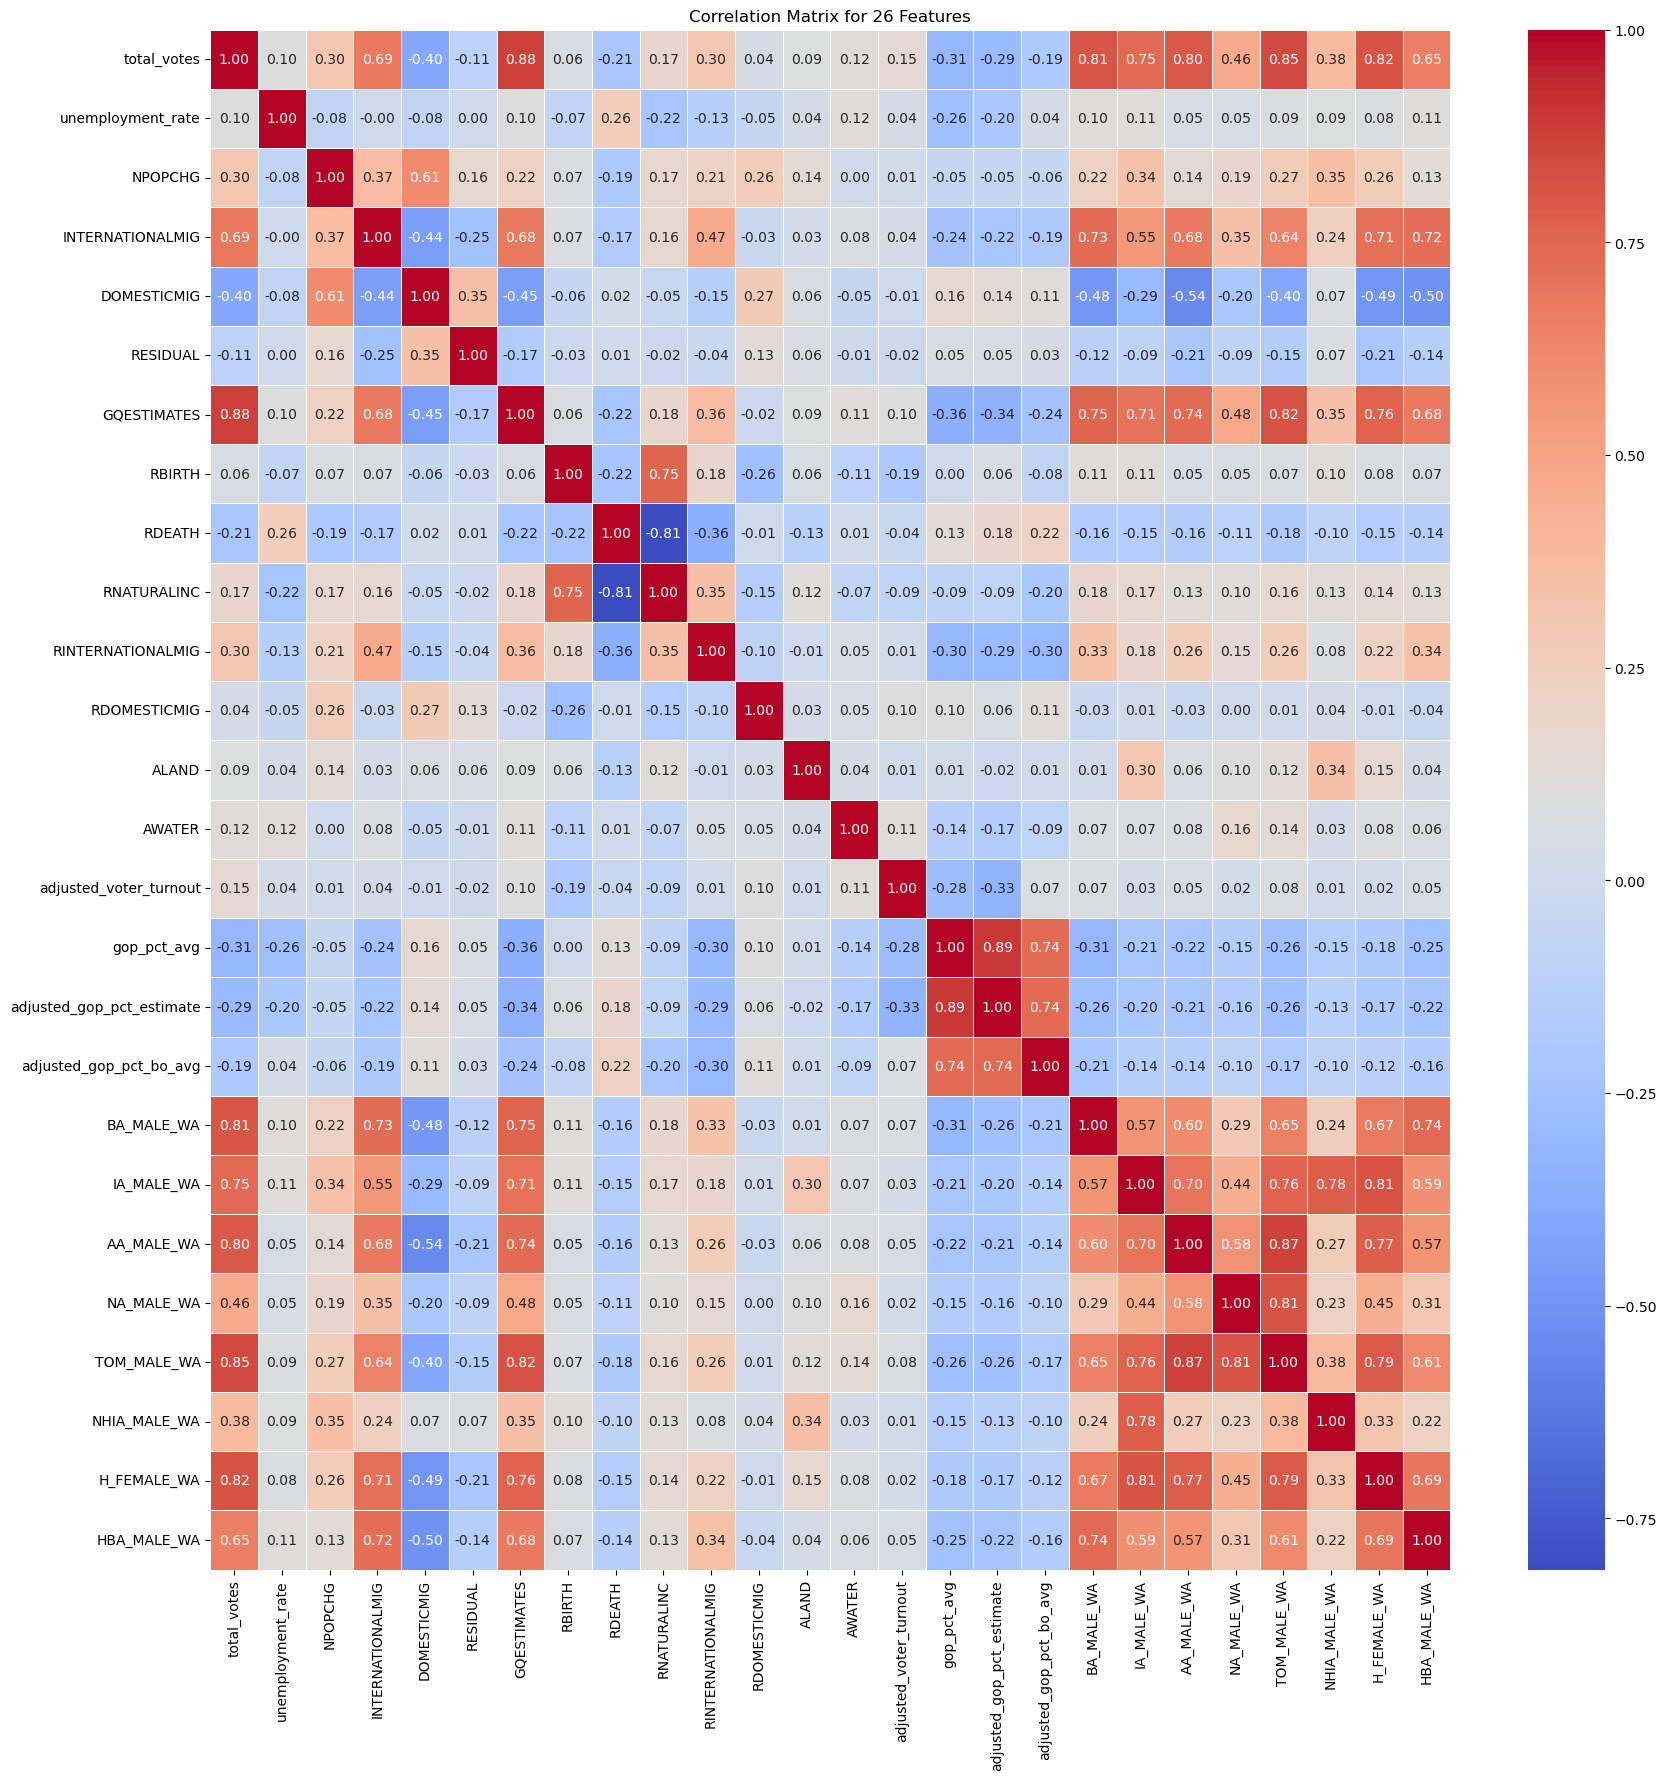

In [25]:
# calculating correlation
corr_matrix = correlation_feature_data.corr()

plt.figure(figsize=(20, 20))  # Adjust the figure size to your liking
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title(f"Correlation Matrix for {corr_matrix.shape[1]} Features")
plt.show()

SAVING DATASET

In [26]:
dataset_columns = ['year', 'state_name', 'fips', 'county_name'] + correlation_feature_data.columns.tolist() + ['image_name', 'per_gop', 'per_dem']

In [27]:
# Getting only relavant columns
dataset = dataset[dataset_columns]

In [28]:
# Checking dataset
dataset.head()

,year,state_name,fips,county_name,total_votes,unemployment_rate,NPOPCHG,INTERNATIONALMIG,DOMESTICMIG,RESIDUAL,...,IA_MALE_WA,AA_MALE_WA,NA_MALE_WA,TOM_MALE_WA,NHIA_MALE_WA,H_FEMALE_WA,HBA_MALE_WA,image_name,per_gop,per_dem
0,2016,Alabama,1001,Autauga County,24661,5.108333,381,7,228,9,...,49,130,15,142,39,324,29,Autauga_01001,0.734358,0.239569
1,2016,Alabama,1003,Baldwin County,94090,5.366667,4873,243,4046,423,...,322,342,39,441,266,1837,75,Baldwin_01003,0.773515,0.195653
2,2016,Alabama,1005,Barbour County,10390,8.341667,-305,-5,-248,9,...,53,30,18,52,21,183,24,Barbour_01005,0.522714,0.466603
3,2016,Alabama,1007,Bibb County,8748,6.466667,82,18,34,1,...,14,9,15,25,12,107,9,Bibb_01007,0.769662,0.214220
4,2016,Alabama,1009,Blount County,25384,5.408333,28,38,-65,14,...,64,21,18,84,40,927,33,Blount_01009,0.898519,0.084699


In [29]:
dataset.to_csv('Dataset.csv', index=False)